In [120]:
import shap
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import joblib

In [2]:
# Bibliotecas dos Modelos Utilizados
from sklearn.linear_model import LogisticRegression  # Regressão Logística.
from sklearn.svm import SVC                          # Máquinas de Vetores de Suporte (SVM).
from sklearn.neighbors import KNeighborsClassifier   # K-Vizinhos Mais Próximos
from sklearn.tree import DecisionTreeClassifier      # Árvore de Decisões de Classificação.
from sklearn.ensemble import RandomForestClassifier  # Floresta Aleatória.
from xgboost import XGBClassifier                    # Extreme Gradient Boosting.

In [3]:
# Análise de Dados
from sklearn.decomposition import PCA

# Treinamento
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Avalição
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.inspection import plot_partial_dependence
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score, classification_report
from sklearn.preprocessing import label_binarize

# Tuning
from sklearn.model_selection import GridSearchCV

# Análise de Dados

In [39]:
# Carregar o DataFrame a partir de um arquivo Excel
caminho_arquivo_excel = 'C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\anonymizedData.xlsx'
nome_da_pagina = 'P_Velocidade Final'  # Nome da página desejada

# Lê o arquivo Excel com todas as páginas/sheets
xl = pd.ExcelFile(caminho_arquivo_excel)

df = xl.parse(nome_da_pagina)

# Vê dados 
df.head()

,DP_Entre-Eixo,DP_Bitola Dianteira,DP_Bitola Traseira,DP_Altura,DP_Comprimento,DP_Altura do CG com relacao ao chao,MV_Eixo dianteiro,MV_Eixo Traseiro,DMV_Dianteira,DMV_Lado Direito,...,CD_Distancia de frenagem de 35 a 0 em asfalto,CD_Distancia de frenagem de 35 a 0 em terra batida,CD_Ganho de rolagem por aceleracao lateral,CD_Ganho de arfagem em aceleracao longitudinal,CD_Ganho de arfagem em desaceleracao longitudinal,CD_Velocidade maxima de 0 a 100 metros em asfalto,CD_Velocidade maxima de 0 a 100 metros em terra batida,CD_Tempo para atingir velocidade maxima em asfalto,CD_Tempo para atingir velocidade maxima em terra batida,P_Velocidade Final
0,1561.118163,1265.646206,1167.249469,1677.640307,2112.956428,NaN,85.014606,110.083747,0.445369,NaN,...,NaN,NaN,NaN,NaN,NaN,45.267951,39.051027,4.890493,8.125734,1
1,1353.642069,1325.068263,1218.350217,339.272891,1846.996203,527.421515,113.024809,148.298659,0.400038,0.600000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,1320.994042,1302.132063,1261.765524,1425.463392,1864.193278,503.697563,83.507934,127.669590,0.417494,0.564572,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,1529.765381,1266.266979,1162.386287,1728.364004,2114.092804,NaN,91.580837,113.147145,0.447466,NaN,...,NaN,NaN,NaN,NaN,NaN,40.524918,41.235969,10.094287,10.519589,1
4,1413.415281,1457.404350,1297.960258,1515.937134,1815.764358,NaN,99.216510,132.864330,0.443812,NaN,...,NaN,NaN,NaN,NaN,NaN,43.566213,NaN,6.249735,NaN,1


In [40]:
# Remove as colunas que não trazem dados relevantes as provas
colunas_a_remover = [
    'DP_Entre-Eixo',
    'DP_Bitola Dianteira',
    'DP_Bitola Traseira',
    'DP_Altura',
    'DP_Comprimento',
    'DP_Altura do CG com relacao ao chao',
    'DMV_Lado Direito',
    'ST_Curso Positivo de projeto',
    'SD_Curso Positivo de projeto',
    'SD_Curso Negativo de projeto',
    'ST_Curso Negativo de projeto',
    'D_Relacao',
    'D_Curso total da cremalheira',
    'D_Inclinacao do pino mestre',
    'D_Angulo de caster',
    'FD_Pressao no sistema a 07g ',
    'FD_Forca no pedal a 07g ',
    'FD_Curso total do pedal ',
    'FD_Diametro do disco ',
    'FT_Pressao no sistema a 07g ',
    'FT_Diametro do disco ',
    'CD_Raio mínimo de curva do protótipo',
    'CD_Velocidade crítica para uma curva de raio de 10 m',
    'CD_Distancia de frenagem de 35 a 0 em asfalto',
    'CD_Distancia de frenagem de 35 a 0 em terra batida',
    'CD_Ganho de rolagem por aceleracao lateral',
    'CD_Ganho de arfagem em aceleracao longitudinal',
    'CD_Ganho de arfagem em desaceleracao longitudinal'
]

# Remove as colunas especificadas
df = df.drop(colunas_a_remover, axis=1)

In [6]:
# Informação básica
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   MV_Eixo dianteiro                                        953 non-null    float64
 1   MV_Eixo Traseiro                                         953 non-null    float64
 2   DMV_Dianteira                                            953 non-null    float64
 3   PCG_X                                                    953 non-null    float64
 4   PCG_Y                                                    1000 non-null   float64
 5   PCG_Z                                                    953 non-null    float64
 6   SD_Dimensoes dos pneus                                   1000 non-null   int64  
 7   SD_Cambagem estatica                                     190 non-null    float64
 8   SD_Convergência estatica     

In [7]:
#Descrição de dados
df.describe()

,MV_Eixo dianteiro,MV_Eixo Traseiro,DMV_Dianteira,PCG_X,PCG_Y,PCG_Z,SD_Dimensoes dos pneus,SD_Cambagem estatica,SD_Convergência estatica,ST_Dimensoes dos pneus,...,ST_Convergência estatica,MT_Potência maxima do motor,MT_Torque maximo do motor,MT_Relacao total_max,MT_Relacao total_min,CD_Velocidade maxima de 0 a 100 metros em asfalto,CD_Velocidade maxima de 0 a 100 metros em terra batida,CD_Tempo para atingir velocidade maxima em asfalto,CD_Tempo para atingir velocidade maxima em terra batida,P_Velocidade Final
count,953.000000,953.000000,953.000000,953.000000,1000.000000,953.000000,1000.000000,190.000000,160.000000,1000.000000,...,141.000000,234.000000,234.000000,927.000000,915.000000,545.000000,433.000000,431.000000,370.000000,1000.000000
mean,73.932834,104.106052,0.414642,303.864779,186.767062,-2988.020885,4.903000,-0.115625,-0.031971,4.915000,...,-0.026372,6.935657,19.003722,28.709048,5.840924,51.617196,48.863131,6.828684,7.471763,3.000000
std,11.939847,13.801997,0.025879,241.495338,234.859193,18853.348280,9.193809,0.461509,0.339432,9.214048,...,0.517186,0.488299,1.398385,5.768065,1.283755,5.050588,5.328800,3.857857,4.147224,1.414921
min,46.099180,75.340037,0.320582,-285.825883,-91.146183,-170275.145241,0.000000,-2.000000,-1.500000,0.000000,...,-2.000000,5.128549,13.858984,3.218078,0.434634,40.023765,25.937922,3.120611,3.743953,1.000000
25%,66.004658,95.719277,0.400140,97.148480,0.016578,154.262348,0.000000,0.000000,0.000000,0.000000,...,0.000000,6.689850,18.574920,26.260096,5.022318,47.606803,45.219761,4.329194,4.674046,2.000000
50%,71.651925,103.551799,0.417215,251.588028,55.130141,251.355163,0.000000,0.000000,0.000000,0.000000,...,0.000000,7.025183,18.802774,28.318460,5.767641,51.935725,49.238482,5.514991,6.174138,3.000000
75%,80.565790,110.728528,0.432229,506.702431,369.667684,420.025489,0.000000,0.000000,0.000000,0.000000,...,0.000000,7.259188,19.548961,31.521034,6.645653,55.436521,52.498481,8.086878,8.526342,4.000000
max,129.610673,169.417592,0.479365,890.686718,984.006876,1015.095842,23.000000,1.970871,1.049839,23.000000,...,2.846394,7.780000,23.000000,53.838854,9.728585,70.679296,61.815220,28.545824,26.970978,5.000000


## Limpeza

In [41]:
# Limpar o Dataset das colunas com muitos valores nulos

limite_nulos = 700 # Define o limite de valores nulos permitidos

# Remove as colunas com mais de limite_nulos valores nulos
df = df.dropna(thresh=len(df) - limite_nulos, axis=1)

# Checar 
df.isnull().sum()

MV_Eixo dianteiro                                           47
MV_Eixo Traseiro                                            47
DMV_Dianteira                                               47
PCG_X                                                       47
PCG_Y                                                        0
PCG_Z                                                       47
SD_Dimensoes dos pneus                                       0
ST_Dimensoes dos pneus                                       0
MT_Relacao total_max                                        73
MT_Relacao total_min                                        85
CD_Velocidade maxima de 0 a 100 metros em asfalto          455
CD_Velocidade maxima de 0 a 100 metros em terra batida     567
CD_Tempo para atingir velocidade maxima em asfalto         569
CD_Tempo para atingir velocidade maxima em terra batida    630
P_Velocidade Final                                           0
dtype: int64

In [42]:
# Pela análise dos dados se percebe que as colunas de Dimensões de Pneus trazem muitos valores zerados
df = df.drop(['SD_Dimensoes dos pneus'], axis=1)
df = df.drop(['ST_Dimensoes dos pneus'], axis=1)

In [43]:
# Verifique quais linhas têm mais de 8 valores iguais nulos
linhas_quase_nulas = df[df.isnull().sum(axis=1) > 8]

# Exiba as linhas que atendem à condição
print(linhas_quase_nulas.index)

# Exclua as linhas com base nos índices coletados
df = df.drop(linhas_quase_nulas.index)

# Exiba o DataFrame resultante
print(df)

Int64Index([805, 809, 811, 817, 820, 830, 838, 848, 854, 866, 867, 876, 878,
            881, 889, 890, 891, 898, 905, 912, 916, 919, 928, 935, 936, 938,
            941, 944, 945, 948, 956, 959, 960, 961, 968, 973, 975, 979, 980,
            984, 985, 987, 990, 993, 994, 996, 999],
           dtype='int64')
     MV_Eixo dianteiro  MV_Eixo Traseiro  DMV_Dianteira       PCG_X  \
0            85.014606        110.083747       0.445369  485.153288   
1           113.024809        148.298659       0.400038  263.935693   
2            83.507934        127.669590       0.417494    9.740746   
3            91.580837        113.147145       0.447466  217.672428   
4            99.216510        132.864330       0.443812  201.426690   
..                 ...               ...            ...         ...   
991          49.723751         86.489072       0.404146   86.777001   
992          65.961657         94.776342       0.441930  478.355026   
995          67.831567         94.846483       0.41

In [44]:
# Mapeie os valores existentes para os novos valores
mapeamento = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}

# Use a função 'replace' para fazer a substituição
df['P_Velocidade Final'] = df['P_Velocidade Final'].replace(mapeamento)

print(df['P_Velocidade Final'])

0      0
1      0
2      0
3      0
4      0
      ..
991    4
992    4
995    4
997    4
998    4
Name: P_Velocidade Final, Length: 953, dtype: int64


In [12]:
# Especificar o caminho para o arquivo Excel existente
caminho_arquivo = "C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\Arquivo_Processado.xlsx"


# Carregar o arquivo Excel existente
planilhas_existentes = pd.ExcelFile(caminho_arquivo)

# Criar um novo arquivo Excel e copiar as planilhas existentes
with pd.ExcelWriter(caminho_arquivo) as writer:
    for sheet_name in planilhas_existentes.sheet_names:
        sheet_data = planilhas_existentes.parse(sheet_name)
        sheet_data.to_excel(writer, sheet_name=sheet_name, index=False)

    novo_dataframe.to_excel(writer, sheet_name='NovoSheet', index=False)

ValueError: Excel file format cannot be determined, you must specify an engine manually.

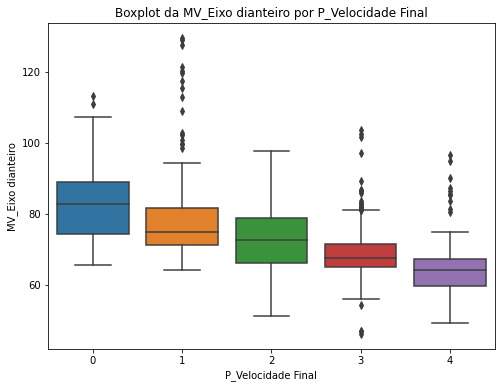

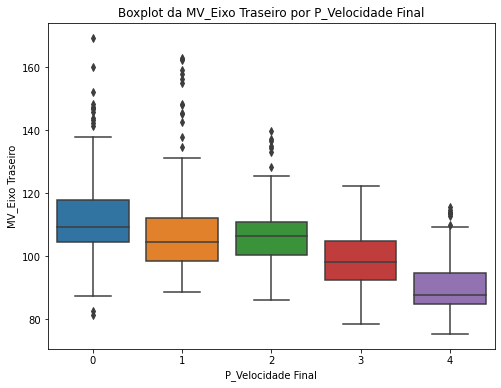

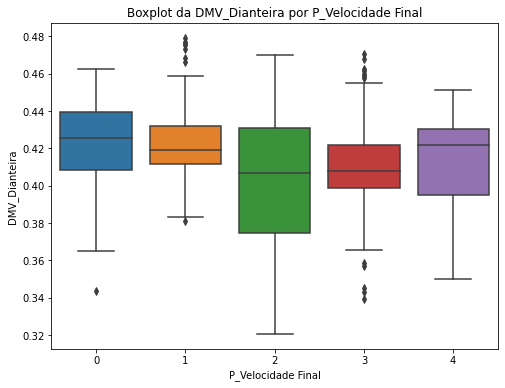

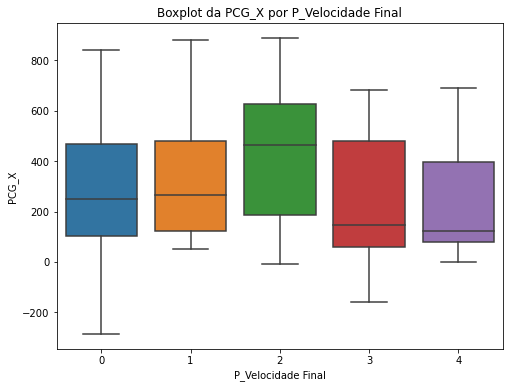

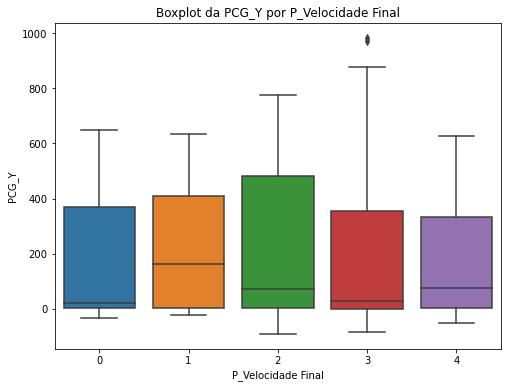

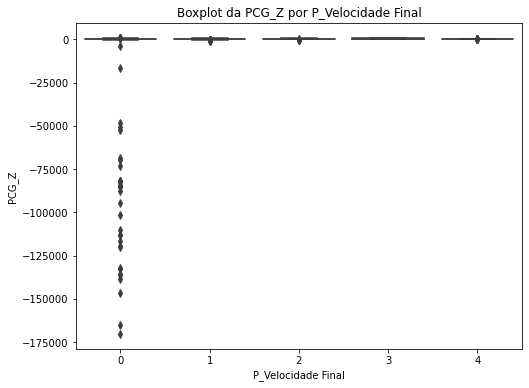

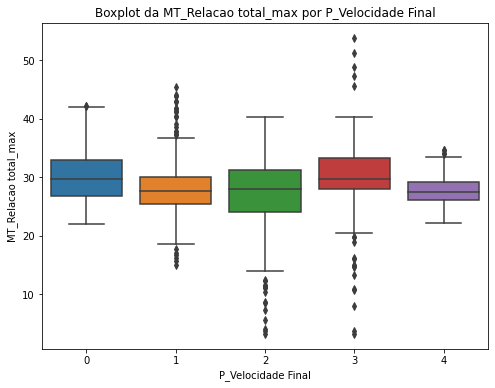

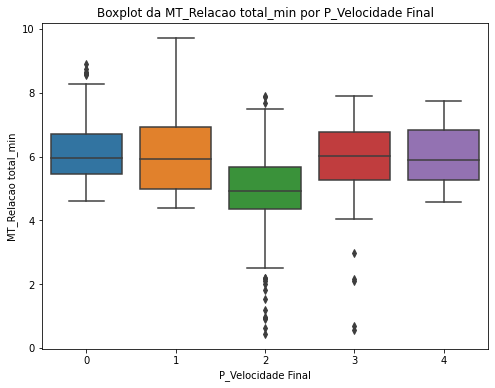

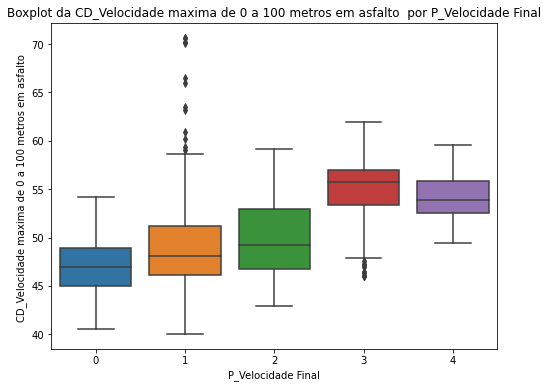

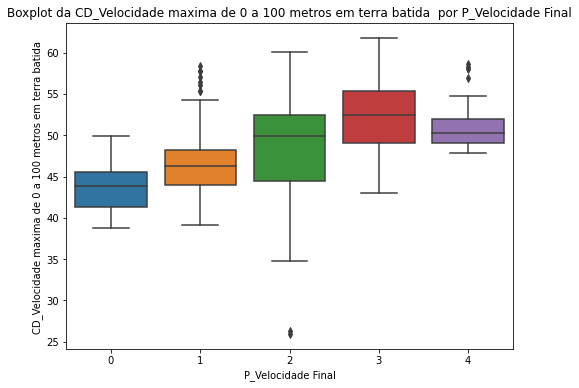

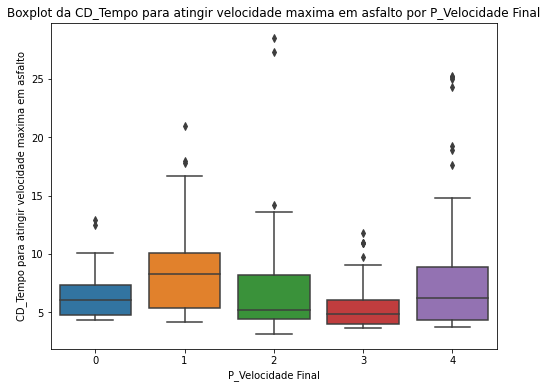

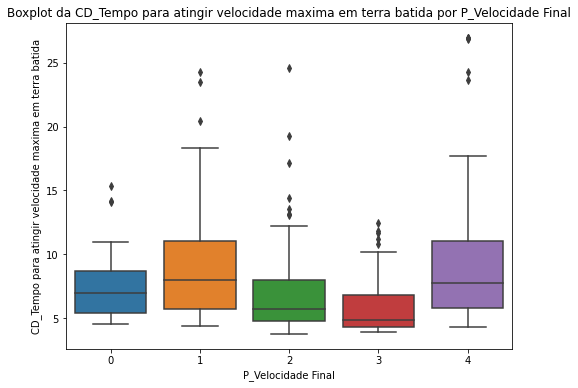

In [45]:
# Boxplots por Classes
for coluna in df.columns:
    if coluna != 'P_Velocidade Final':  # Excluindo a coluna de classe das análises
        plt.figure(figsize=(8, 6))
        sns.boxplot(x='P_Velocidade Final', y=coluna, data=df)
        plt.title(f'Boxplot da {coluna} por P_Velocidade Final')
        plt.ylabel(coluna)
        plt.xlabel('P_Velocidade Final')
        plt.show()

In [46]:
# Tratar Outliers e valores nulos
colunas_a_tratar = df.columns.difference(['P_Velocidade Final']) # Lista das colunas a serem tratadas 


# Lista das classes únicas na coluna 'Classe'
classes_unicas = df['P_Velocidade Final'].unique()

# Função para tratar uma coluna específica em uma classe
def tratar_coluna_para_classe(data, classe, coluna):
    dados_classe = data[data['P_Velocidade Final'] == classe]
    
    # Calcula a mediana dos valores não nulos da coluna para esta classe
    mediana = dados_classe[coluna].median()
    
    # Calcula o desvio padrão dos valores não nulos da coluna para esta classe
    desvio_padrao = dados_classe[coluna].std()
    
    # Define o limite superior e inferior com base no desvio padrão
    limite_superior = mediana + (2 * desvio_padrao)
    limite_inferior = mediana - (2 * desvio_padrao)
    
    # Substitui os valores que são nulos ou estão fora do limite pelo valor da mediana
    dados_classe[coluna] = dados_classe[coluna].apply(lambda x: mediana if pd.isna(x) or x > limite_superior or x < limite_inferior else x)
    
    return dados_classe

# Loop para tratar todas as colunas para cada classe
dados_tratados = []
for classe in classes_unicas:
    dados_classe = df[df['P_Velocidade Final'] == classe].copy()  # Crie uma cópia dos dados da classe
    for coluna in colunas_a_tratar:
        dados_classe = tratar_coluna_para_classe(dados_classe, classe, coluna)
    dados_tratados.append(dados_classe)

# Concatena os dados tratados de volta em um único DataFrame
df_tratado = pd.concat(dados_tratados)

#print(df)

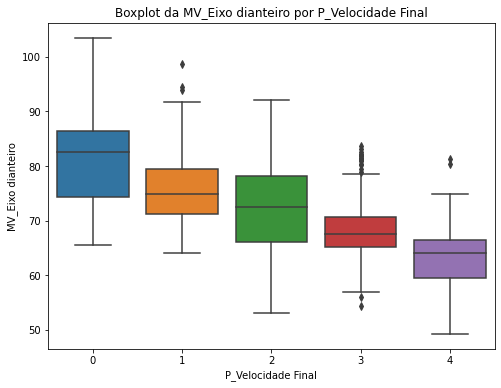

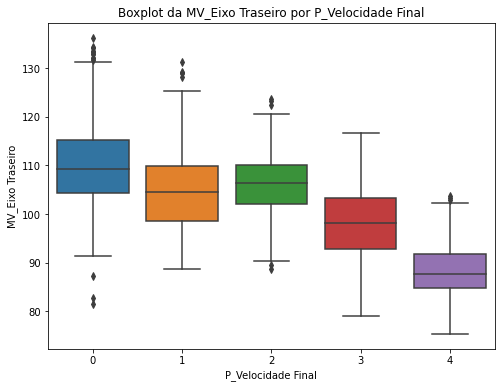

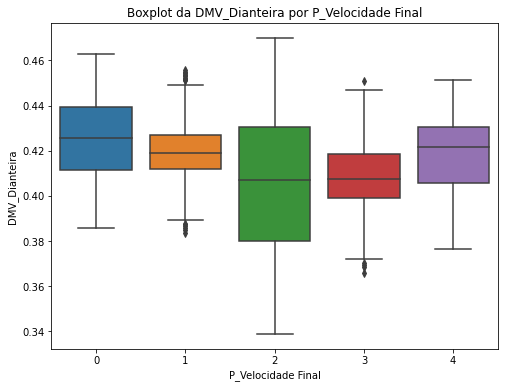

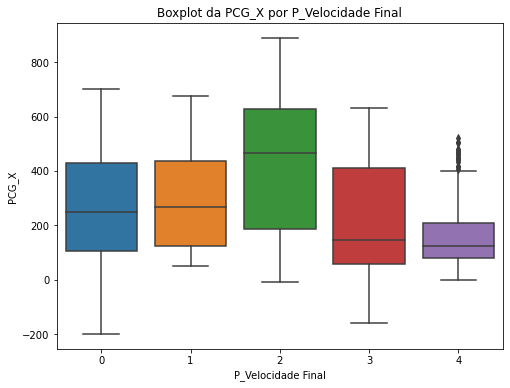

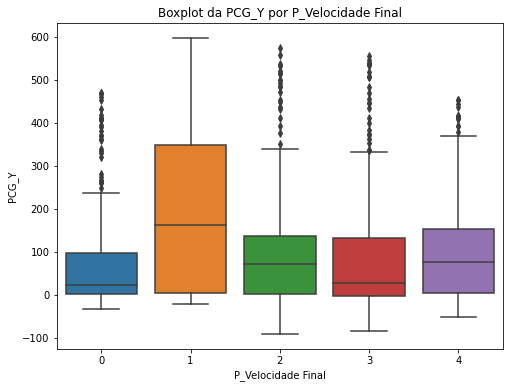

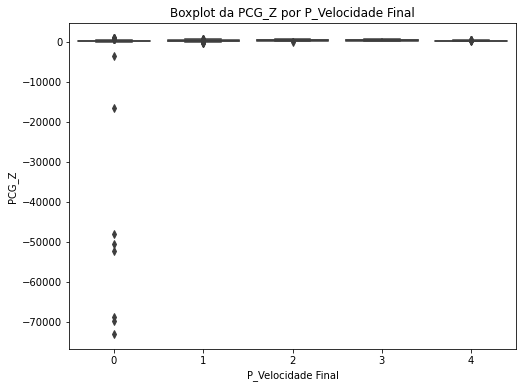

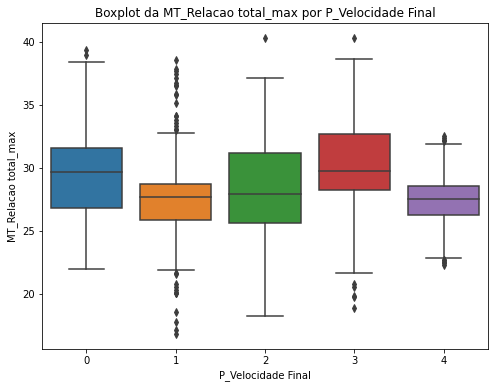

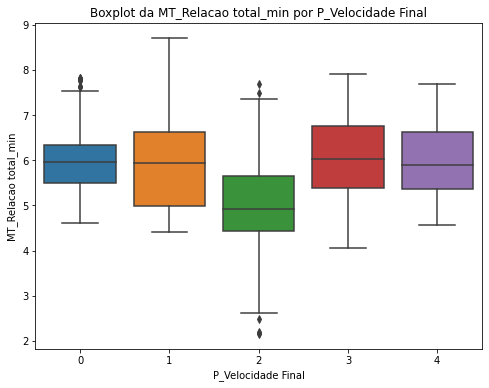

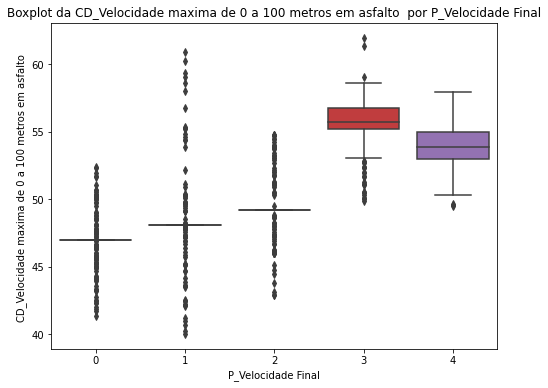

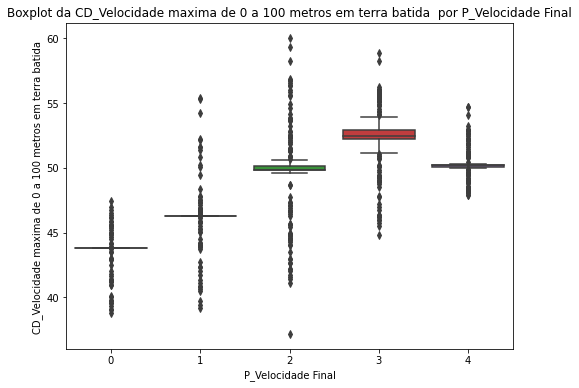

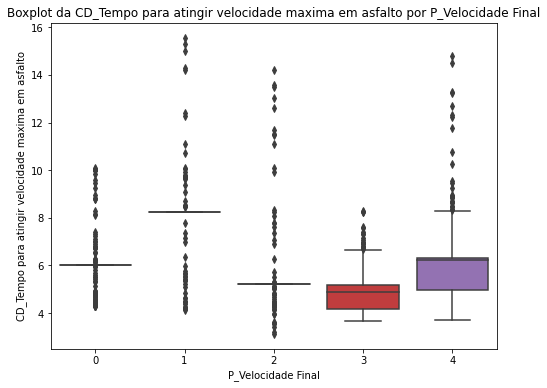

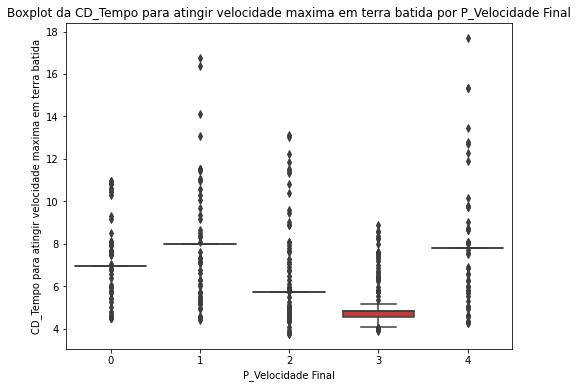

In [47]:
# Boxplots por Classes
for coluna in df_tratado.columns:
    if coluna != 'P_Velocidade Final':  # Excluindo a coluna de classe das análises
        plt.figure(figsize=(8, 6))
        sns.boxplot(x='P_Velocidade Final', y=coluna, data=df_tratado)
        plt.title(f'Boxplot da {coluna} por P_Velocidade Final')
        plt.ylabel(coluna)
        plt.xlabel('P_Velocidade Final')
        plt.show()

In [48]:
df = df_tratado

In [ ]:
# Especifique o caminho para o arquivo Excel
caminho_arquivo = "C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\Arquivo_Processado_semO.xlsx"

# Carregar o arquivo Excel existente
book = load_workbook(caminho_arquivo)

# Adicionar o DataFrame como um novo sheet
with pd.ExcelWriter(caminho_arquivo, engine='openpyxl', mode='a') as writer:
    writer.book = book
    novo_dataframe.to_excel(writer, sheet_name='P_Velocidade', index=False)

## Análise de Variáveis

In [49]:
data_corr = df.drop(['P_Velocidade Final'], axis=1)
# Análise de correlação dos parâmetros
correlation = df.corr()

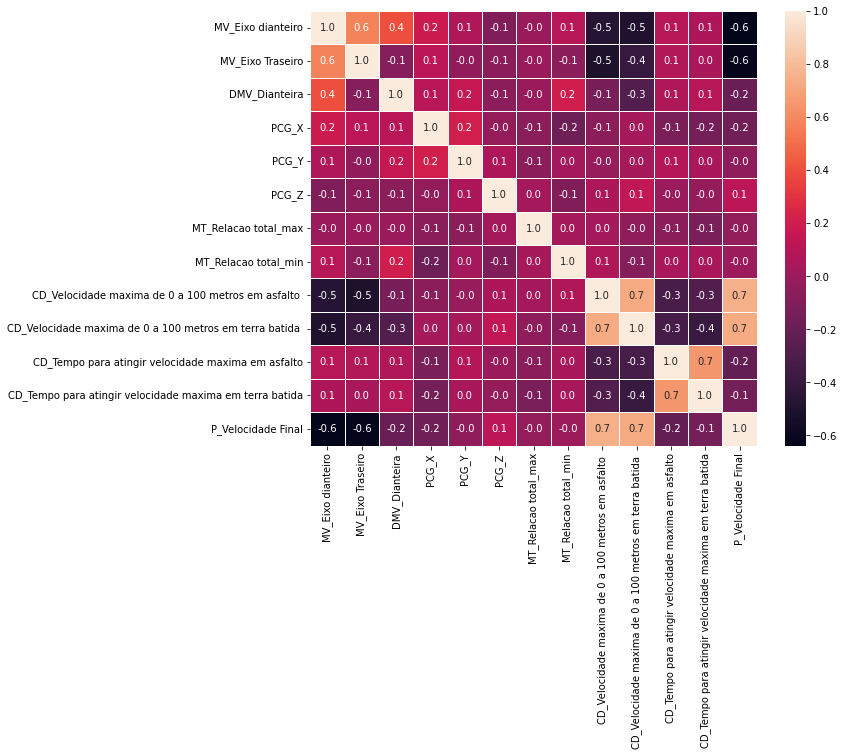

In [51]:
# Plot da matriz de correlação
plt.figure(figsize=(10, 8))

plot = sns.heatmap(correlation, annot = True, fmt=".1f", linewidths=0.5)
plt.show()

In [52]:
# Aplicar PCA para reduzir variáveis de alta correlação - Massa
variaveis_reduzidas = df[['MV_Eixo dianteiro', 'MV_Eixo Traseiro']]

pca = PCA(n_components=1)
variavel_reduzida = pca.fit_transform(variaveis_reduzidas)

# Remove as colunas reduzidas
colunas_a_remover = [
    'MV_Eixo dianteiro',
    'MV_Eixo Traseiro',
]

df = df.drop(colunas_a_remover, axis=1)

# Escolha a posição (índice) onde deseja inserir a nova coluna
posicao_desejada = 0

# Insira a nova coluna no DataFrame na posição desejada
df.insert(posicao_desejada, 'Massa', variavel_reduzida)

print(df)

         Massa  DMV_Dianteira       PCG_X      PCG_Y         PCG_Z  \
0    13.918990       0.445369  485.153288 -19.827850 -68764.325890   
1    11.782514       0.400038  263.935693   7.110928    251.177947   
2    26.714465       0.417494    9.740746   1.319692    185.975386   
3    20.411818       0.447466  217.672428 -20.970397    126.250912   
4    40.580643       0.443812  201.426690  22.438382    -27.267006   
..         ...            ...         ...        ...           ...   
991 -26.546686       0.404146   86.777001   0.016778    181.084548   
992  -9.934422       0.441930  478.355026  75.310605    192.501465   
995  -8.712045       0.412839   77.704667  75.310605    315.726447   
997 -21.618540       0.420964  134.416344  75.310605    358.939170   
998 -23.001367       0.434142  395.941259  75.310605    203.568774   

     MT_Relacao total_max  MT_Relacao total_min  \
0               25.470433              7.040260   
1               29.636217              6.346492   
2     

In [54]:
# Aplicar PCA para reduzir variáveis de alta correlação - Velocidade maxima de 0 a 100 metros
variaveis_reduzidas = df[['CD_Velocidade maxima de 0 a 100 metros em asfalto ', 'CD_Velocidade maxima de 0 a 100 metros em terra batida ']]

pca = PCA(n_components=1)
variavel_reduzida = pca.fit_transform(variaveis_reduzidas)

# Remove as colunas reduzidas
colunas_a_remover = [
    'CD_Velocidade maxima de 0 a 100 metros em asfalto ',
    'CD_Velocidade maxima de 0 a 100 metros em terra batida ',
]

df = df.drop(colunas_a_remover, axis=1)

# Escolha a posição (índice) onde deseja inserir a nova coluna
posicao_desejada = 7

# Insira a nova coluna no DataFrame na posição desejada
df.insert(posicao_desejada, 'CD_Velocidade maxima de 0 a 100 metros', variavel_reduzida)

print(df)

         Massa  DMV_Dianteira       PCG_X      PCG_Y         PCG_Z  \
0    13.918990       0.445369  485.153288 -19.827850 -68764.325890   
1    11.782514       0.400038  263.935693   7.110928    251.177947   
2    26.714465       0.417494    9.740746   1.319692    185.975386   
3    20.411818       0.447466  217.672428 -20.970397    126.250912   
4    40.580643       0.443812  201.426690  22.438382    -27.267006   
..         ...            ...         ...        ...           ...   
991 -26.546686       0.404146   86.777001   0.016778    181.084548   
992  -9.934422       0.441930  478.355026  75.310605    192.501465   
995  -8.712045       0.412839   77.704667  75.310605    315.726447   
997 -21.618540       0.420964  134.416344  75.310605    358.939170   
998 -23.001367       0.434142  395.941259  75.310605    203.568774   

     MT_Relacao total_max  MT_Relacao total_min  \
0               25.470433              7.040260   
1               29.636217              6.346492   
2     

In [55]:
# Aplicar PCA para reduzir variáveis de alta correlação - Tempo para atingir velocidade maxima
variaveis_reduzidas = df[['CD_Tempo para atingir velocidade maxima em asfalto', 'CD_Tempo para atingir velocidade maxima em terra batida']]

pca = PCA(n_components=1)
variavel_reduzida = pca.fit_transform(variaveis_reduzidas)

# Remove as colunas reduzidas
colunas_a_remover = [
    'CD_Tempo para atingir velocidade maxima em asfalto',
    'CD_Tempo para atingir velocidade maxima em terra batida',
]

df = df.drop(colunas_a_remover, axis=1)

# Escolha a posição (índice) onde deseja inserir a nova coluna
posicao_desejada = 8

# Insira a nova coluna no DataFrame na posição desejada
df.insert(posicao_desejada, 'CD_Tempo para atingir velocidade maxima', variavel_reduzida)

print(df)

         Massa  DMV_Dianteira       PCG_X      PCG_Y         PCG_Z  \
0    13.918990       0.445369  485.153288 -19.827850 -68764.325890   
1    11.782514       0.400038  263.935693   7.110928    251.177947   
2    26.714465       0.417494    9.740746   1.319692    185.975386   
3    20.411818       0.447466  217.672428 -20.970397    126.250912   
4    40.580643       0.443812  201.426690  22.438382    -27.267006   
..         ...            ...         ...        ...           ...   
991 -26.546686       0.404146   86.777001   0.016778    181.084548   
992  -9.934422       0.441930  478.355026  75.310605    192.501465   
995  -8.712045       0.412839   77.704667  75.310605    315.726447   
997 -21.618540       0.420964  134.416344  75.310605    358.939170   
998 -23.001367       0.434142  395.941259  75.310605    203.568774   

     MT_Relacao total_max  MT_Relacao total_min  \
0               25.470433              7.040260   
1               29.636217              6.346492   
2     

In [56]:
# Dividir o conjunto de dados em treinamento e teste
dados_treino, dados_teste = train_test_split(df, test_size=0.3)

# Separar X e Y
X = df.iloc[:, :-1]
Y = df.iloc[:, -1]

X_treino = dados_treino.iloc[:, :-1]
Y_treino = dados_treino.iloc[:, -1]

X_teste = dados_teste.iloc[:, :-1]
Y_teste = dados_teste.iloc[:, -1]

print(dados_treino)

732    3
591    2
222    1
327    1
5      0
      ..
565    2
195    0
148    0
4      0
193    0
Name: P_Velocidade Final, Length: 286, dtype: int64


# Escolha do Modelo

## Regressão Logística:

In [57]:
# Modelo de regressão logística.
model_LR = LogisticRegression()
model_LR.fit(X_treino, Y_treino)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression()

In [58]:
# Avaliação do desempenho do modelo.
Y_pred = model_LR.predict(X_teste)

acuracia = accuracy_score(Y_teste, Y_pred)
relatorio_classificacao = classification_report(Y_teste, Y_pred)
    
print(f"Desempenho para Regressão Logística:")
print(f'Acurácia: {acuracia:.2f}')
print('Relatório de Classificação:')
print(relatorio_classificacao)

Desempenho para Regressão Logística:
Acurácia: 0.73
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.70      0.86      0.77        63
           1       0.83      0.61      0.70        64
           2       0.73      0.69      0.71        65
           3       0.77      0.71      0.74        58
           4       0.64      0.83      0.72        36

    accuracy                           0.73       286
   macro avg       0.73      0.74      0.73       286
weighted avg       0.74      0.73      0.73       286



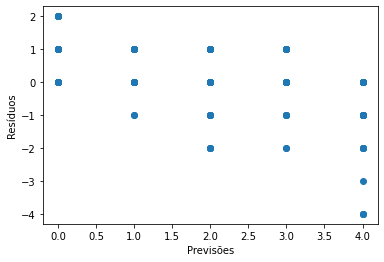

In [59]:
# Analisar os resíduos
residuos = Y_teste - Y_pred

# Plote um gráfico de dispersão dos resíduos em relação às previsões
plt.scatter(Y_pred, residuos)
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.show()

## Máquinas de Vetores de Suporte (SVM)

In [60]:
# Modelo SVM com um kernel linear e "um contra todos"
model_SVM = SVC(kernel='linear', decision_function_shape='ovr')
model_SVM.fit(X_treino, Y_treino)

SVC(kernel='linear')

In [61]:
# Avaliação do desempenho do modelo.
Y_pred = model_SVM.predict(X_teste)

acuracia = accuracy_score(Y_teste, Y_pred)
relatorio_classificacao = classification_report(Y_teste, Y_pred)
    
print(f"Desempenho para Máquinas de Vetores de Suporte:")
print(f'Acurácia: {acuracia:.2f}')
print('Relatório de Classificação:')
print(relatorio_classificacao)

Desempenho para Máquinas de Vetores de Suporte:
Acurácia: 0.83
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.78      0.94      0.85        63
           1       0.80      0.80      0.80        64
           2       0.90      0.72      0.80        65
           3       0.89      0.83      0.86        58
           4       0.80      0.89      0.84        36

    accuracy                           0.83       286
   macro avg       0.83      0.83      0.83       286
weighted avg       0.84      0.83      0.83       286



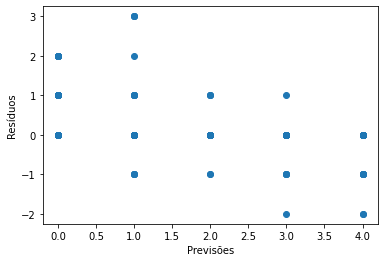

In [62]:
# Analisar os resíduos
residuos = Y_teste - Y_pred

# Plote um gráfico de dispersão dos resíduos em relação às previsões
plt.scatter(Y_pred, residuos)
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.show()

## K-Nearest Neighbors

In [63]:
k = 3  # Número de vizinhos (Altere por necessidade)

# Modelo de K-Vizinhos Mais Próximos (K-Nearest Neighbors - KNN).
model_KNN = KNeighborsClassifier(n_neighbors=k)
model_KNN.fit(X_treino, Y_treino)

KNeighborsClassifier(n_neighbors=3)

In [64]:
# Avaliação do desempenho do modelo usando as métricas de erro quadrático médio (RMSE) e o coeficiente de determinação (R2).
Y_pred = model_KNN.predict(X_teste)

acuracia = accuracy_score(Y_teste, Y_pred)
relatorio_classificacao = classification_report(Y_teste, Y_pred)
    
print(f"Desempenho para K-Vizinhos Mais Próximos:")
print(f'Acurácia: {acuracia:.2f}')
print('Relatório de Classificação:')
print(relatorio_classificacao)

Desempenho para K-Vizinhos Mais Próximos:
Acurácia: 0.60
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.59      0.78      0.67        63
           1       0.51      0.55      0.53        64
           2       0.55      0.51      0.53        65
           3       0.74      0.45      0.56        58
           4       0.70      0.78      0.74        36

    accuracy                           0.60       286
   macro avg       0.62      0.61      0.61       286
weighted avg       0.61      0.60      0.59       286



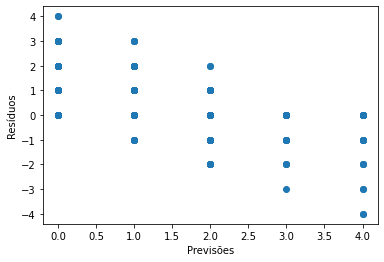

In [65]:
# Analisar os resíduos
residuos = Y_teste - Y_pred

# Plote um gráfico de dispersão dos resíduos em relação às previsões
plt.scatter(Y_pred, residuos)
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.show()

## Decision Tree Classifier

In [66]:
# Modelo de Árvore de Decisão de Classificação.
model_DTC = DecisionTreeClassifier()
model_DTC.fit(X_treino, Y_treino)

DecisionTreeClassifier()

In [67]:
# Avaliação do desempenho do modelo usando as métricas de erro quadrático médio (RMSE) e o coeficiente de determinação (R2).
Y_pred = model_DTC.predict(X_teste)

acuracia = accuracy_score(Y_teste, Y_pred)
relatorio_classificacao = classification_report(Y_teste, Y_pred)
    
print(f"Desempenho para Árvore de Decisão de Classificação:")
print(f'Acurácia: {acuracia:.2f}')
print('Relatório de Classificação:')
print(relatorio_classificacao)

Desempenho para Árvore de Decisão de Classificação:
Acurácia: 0.84
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89        63
           1       0.90      0.84      0.87        64
           2       0.74      0.82      0.77        65
           3       0.90      0.81      0.85        58
           4       0.78      0.89      0.83        36

    accuracy                           0.84       286
   macro avg       0.84      0.85      0.84       286
weighted avg       0.85      0.84      0.84       286



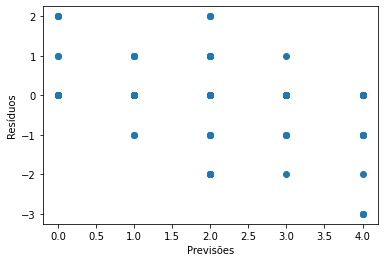

In [68]:
# Analisar os resíduos
residuos = Y_teste - Y_pred

# Plote um gráfico de dispersão dos resíduos em relação às previsões
plt.scatter(Y_pred, residuos)
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.show()

## Random Forest Classifier

In [76]:
# Modelo de Regressão de Floresta Aleatória.
model_RFC = RandomForestClassifier()
model_RFC.fit(X_treino, Y_treino)

RandomForestClassifier()

In [77]:
# Avaliação do desempenho do modelo.
Y_pred = model_RFC.predict(X_teste)

acuracia = accuracy_score(Y_teste, Y_pred)
relatorio_classificacao = classification_report(Y_teste, Y_pred)
    
print(f"Desempenho para Regressão de Floresta Aleatória:")
print(f'Acurácia: {acuracia:.2f}')
print('Relatório de Classificação:')
print(relatorio_classificacao)

Desempenho para Regressão de Floresta Aleatória:
Acurácia: 0.92
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        63
           1       0.97      0.89      0.93        64
           2       0.89      0.89      0.89        65
           3       0.93      0.88      0.90        58
           4       0.88      0.97      0.92        36

    accuracy                           0.92       286
   macro avg       0.92      0.93      0.92       286
weighted avg       0.92      0.92      0.92       286



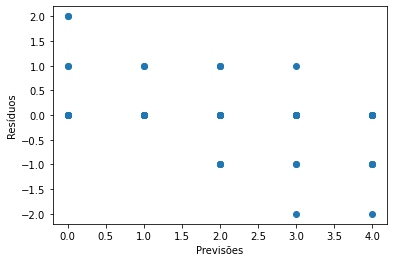

In [78]:
# Analisar os resíduos.
residuos = Y_teste - Y_pred

# Plote um gráfico de dispersão dos resíduos em relação às previsões
plt.scatter(Y_pred, residuos)
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.show()

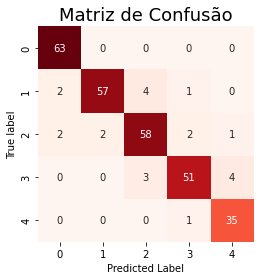

In [80]:
# Matriz de Confusão

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(Y_teste, Y_pred), annot=True, ax=ax, fmt='d', cmap='Reds', cbar=False, square=True)
ax.set_title("Matriz de Confusão", fontsize=18)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted Label")
plt.tight_layout()

## XGBoost

In [81]:
# Modelo de Extreme Gradient Boosting.
model_XGB = XGBClassifier()
model_XGB.fit(X_treino, Y_treino)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [82]:
# Avaliação do desempenho do modelo usando as métricas de erro quadrático médio (RMSE) e o coeficiente de determinação (R2).
Y_pred = model_XGB.predict(X_teste)

acuracia = accuracy_score(Y_teste, Y_pred)
relatorio_classificacao = classification_report(Y_teste, Y_pred)
    
print(f"Desempenho para Extreme Gradient Boosting:")
print(f'Acurácia: {acuracia:.2f}')
print('Relatório de Classificação:')
print(relatorio_classificacao)

Desempenho para Extreme Gradient Boosting:
Acurácia: 0.93
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97        63
           1       1.00      0.94      0.97        64
           2       0.89      0.95      0.92        65
           3       0.94      0.84      0.89        58
           4       0.87      0.94      0.91        36

    accuracy                           0.93       286
   macro avg       0.93      0.93      0.93       286
weighted avg       0.94      0.93      0.93       286



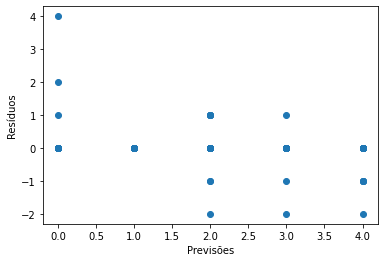

In [83]:
# Analisar os resíduos
residuos = Y_teste - Y_pred

# Plote um gráfico de dispersão dos resíduos em relação às previsões
plt.scatter(Y_pred, residuos)
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.show()

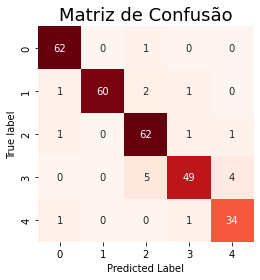

In [84]:
# Matriz de Confusão

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(Y_teste, Y_pred), annot=True, ax=ax, fmt='d', cmap='Reds', cbar=False, square=True)
ax.set_title("Matriz de Confusão", fontsize=18)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted Label")
plt.tight_layout()

# Treinamento do Modelo

## Bootstraps

In [85]:
n_iterations = 100  # Número de iterações do Bootstrap

# Lista para armazenar as métricas de desempenho em cada iteração
performance_metrics = []

for _ in range(n_iterations):
    # Amostragem Bootstrap: crie um conjunto de treinamento com reamostragem
    indices_amostra = np.random.choice(len(X_treino), size=len(X_treino), replace=True)
    X_bootstrap = X_treino.iloc[indices_amostra]  
    y_bootstrap = Y_treino.iloc[indices_amostra]

    # Crie e treine seu modelo
    model_XGB.fit(X_bootstrap, y_bootstrap)

    # Avalie o modelo no conjunto de teste
    desempenho = model_XGB.score(X_teste, Y_teste)  # Mede a acurácia
    performance_metrics.append(desempenho)

In [86]:
# Calcule as métricas resumidas (por exemplo, média e desvio padrão)
media_desempenho = np.mean(performance_metrics)
desvio_padrao_desempenho = np.std(performance_metrics)

# Imprima as métricas resumidas
print(f'Média do desempenho: {media_desempenho:.4f}')
print(f'Desvio Padrão do desempenho: {desvio_padrao_desempenho:.4f}')

Média do desempenho: 0.9167
Desvio Padrão do desempenho: 0.0117


# Avaliação do Modelo

## Cross-Validation

In [87]:
# Número de classes
n_classes = 5

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [89]:
# Calcule a média das pontuações para avaliação de Acurácia do modelo
def intervalo(results):
    mean = results.mean()
    dv = results.std()
    print('Acurácia média: {:.2f}%'.format(mean * 100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'.format((mean - 2 * dv) * 100, (mean + 2 * dv) * 100))

scores = cross_val_score(model_XGB, X_treino, Y_treino, cv=kfold, scoring='accuracy') # Checar Modelo
intervalo(scores)

Acurácia média: 91.75%
Intervalo de acurácia: [87.50% ~ 96.01%]


In [91]:
# Calcule a média das pontuações para avaliação de Precisão do modelo
def intervalo_prec(results):
    mean = results.mean()
    dv = results.std()
    print('Precisão média: {:.2f}%'.format(mean * 100))
    print('Intervalo de Precisão: [{:.2f}% ~ {:.2f}%]'.format((mean - 2 * dv) * 100, (mean + 2 * dv) * 100))

scores = cross_val_score(model_XGB, X_treino, Y_treino, cv=kfold, scoring='precision_macro') # Checar Modelo
intervalo_prec(scores)

Precisão média: 91.64%
Intervalo de Precisão: [87.34% ~ 95.93%]


In [92]:
# Calcule a média das pontuações para avaliação de Recall do modelo
def intervalo_recall(results):
    mean = results.mean()
    dv = results.std()
    print('Recall médio: {:.2f}%'.format(mean * 100))
    print('Intervalo de Recall: [{:.2f}% ~ {:.2f}%]'.format((mean - 2 * dv) * 100, (mean + 2 * dv) * 100))

scores = cross_val_score(model_XGB, X_treino, Y_treino, cv=kfold, scoring='recall_macro') # Checar Modelo
intervalo_recall(scores)

Recall médio: 91.78%
Intervalo de Recall: [88.02% ~ 95.54%]


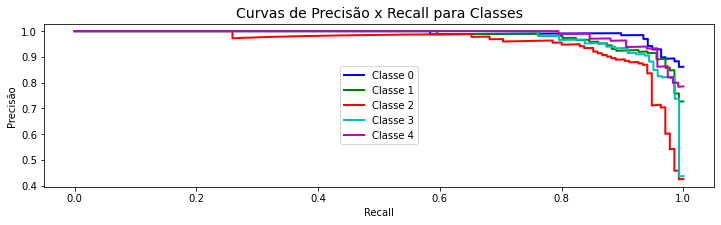

In [98]:
# Comparar scores de Previsão e Recall
# Converta Y_treino para uma matriz binária de classes
Y_bin = label_binarize(Y_treino, classes=list(range(5)))

# Obter as probabilidades em vez das previsões
y_scores = cross_val_predict(model_XGB, X_treino, Y_treino, cv=kfold, method='predict_proba')

# Calcula as curvas de precisão e recall para cada classe
precisions = dict()
recalls = dict()
for i in range(5):
    precision, recall, _ = precision_recall_curve(Y_bin[:, i], y_scores[:, i])
    precisions[i] = precision
    recalls[i] = recall

# Plote as curvas de precisão e recall para cada classe
fig, ax = plt.subplots(figsize=(12, 3))
colors = ['b', 'g', 'r', 'c', 'm']
for i, color in zip(range(5), colors):
    plt.plot(recalls[i], precisions[i], color, lw=2, label='Classe {}'.format(i))

plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.legend(loc='center')
plt.title('Curvas de Precisão x Recall para Classes', fontsize=14)
plt.show()

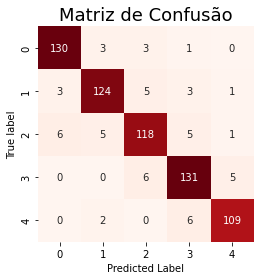

In [99]:
# Matriz de Confusão
Y_pred = cross_val_predict(model_XGB, X_treino, Y_treino, cv=kfold) # Checar Modelo

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(Y_treino, Y_pred), annot=True, ax=ax, fmt='d', cmap='Reds', cbar=False, square=True)
ax.set_title("Matriz de Confusão", fontsize=18)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted Label")
plt.tight_layout()

In [100]:
# Relatório do modelo
print('Relatório de classificação:\n', classification_report(Y_treino, Y_pred, digits=4))

Relatório de classificação:
               precision    recall  f1-score   support

           0     0.9353    0.9489    0.9420       137
           1     0.9254    0.9118    0.9185       136
           2     0.8939    0.8741    0.8839       135
           3     0.8973    0.9225    0.9097       142
           4     0.9397    0.9316    0.9356       117

    accuracy                         0.9175       667
   macro avg     0.9183    0.9178    0.9180       667
weighted avg     0.9176    0.9175    0.9175       667



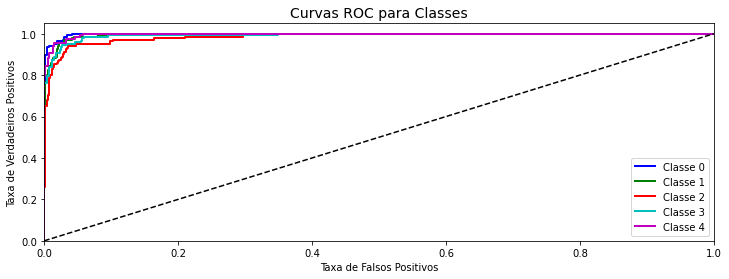

In [101]:
# Receiver operating characteristic — ROC

# Converta Y_treino para uma matriz binária de classes
Y_bin = label_binarize(Y_treino, classes=list(range(5)))

# Calcula as curvas ROC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(Y_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plote as curvas ROC para cada classe
fig, ax = plt.subplots(figsize=(12, 4))
colors = ['b', 'g', 'r', 'c', 'm']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color, lw=2, label='Classe {}'.format(i))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc='lower right')
plt.title('Curvas ROC para Classes', fontsize=14)
plt.show()

In [102]:
# Área sob a Curva
print('Área sob a curva ROC: {:.4f}'.format(roc_auc_score(Y_treino, y_scores, multi_class='ovr', average='macro')))

Área sob a curva ROC: 0.9934


In [103]:
# Treinamento do modelo 
model_XGB.fit(X_treino, Y_treino) # Checar modelo

# Fazer previsões no conjunto de teste
Y_pred_teste = model_XGB.predict(X_teste)

# Acurácia no conjunto de teste
accuracy = accuracy_score(Y_teste, Y_pred_teste)
print('Acurácia no conjunto de teste: {:.2f}%'.format(accuracy * 100))

# Precisão no conjunto de teste
precision = precision_score(Y_teste, Y_pred_teste, average='macro')
print('Precisão no conjunto de teste: {:.2f}%'.format(precision * 100))

# Recall no conjunto de teste
recall = recall_score(Y_teste, Y_pred_teste, average='macro')
print('Recall no conjunto de teste: {:.2f}%'.format(recall * 100))

# Relatório de classificação no conjunto de teste
print('Relatório de classificação no conjunto de teste:\n', classification_report(Y_teste, Y_pred_teste, digits=4))

Acurácia no conjunto de teste: 93.36%
Precisão no conjunto de teste: 93.07%
Recall no conjunto de teste: 93.29%
Relatório de classificação no conjunto de teste:
               precision    recall  f1-score   support

           0     0.9538    0.9841    0.9688        63
           1     1.0000    0.9375    0.9677        64
           2     0.8857    0.9538    0.9185        65
           3     0.9423    0.8448    0.8909        58
           4     0.8718    0.9444    0.9067        36

    accuracy                         0.9336       286
   macro avg     0.9307    0.9329    0.9305       286
weighted avg     0.9360    0.9336    0.9335       286



## Análise de Variáveis 

In [104]:
# Analisar variáveis que mais afetam o modelo
importances = model_XGB.feature_importances_

# Classifique as importâncias das características
indices_ordenados = np.argsort(importances)[::-1]

print(importances)

[0.18458205 0.03875114 0.08359592 0.0540662  0.06151942 0.04820479
 0.06097891 0.23028609 0.2380155 ]


<Figure size 1440x1152 with 0 Axes>

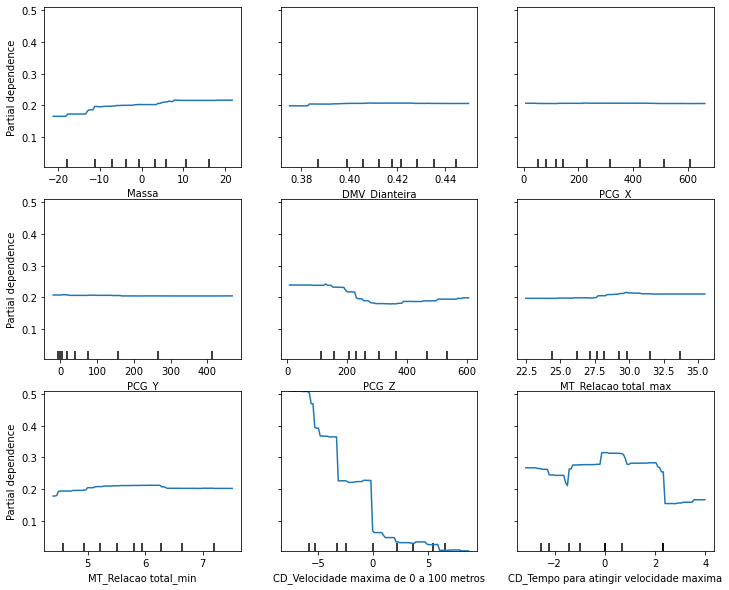

In [115]:
# Analisar como uma variável afeta as previsões
colunas = df.columns[:-1].tolist() # Separar as variáveis

plt.figure(figsize=(20, 16))

# Crie PDPs para as variáveis escolhidas
plot_partial_dependence(model_XGB, X_treino, features=colunas, target=Y_treino.all(), grid_resolution=100)

# Obter a figura atual e definir o tamanho
fig = plt.gcf()
fig.set_size_inches(12, 10)

plt.show()

[09:16:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


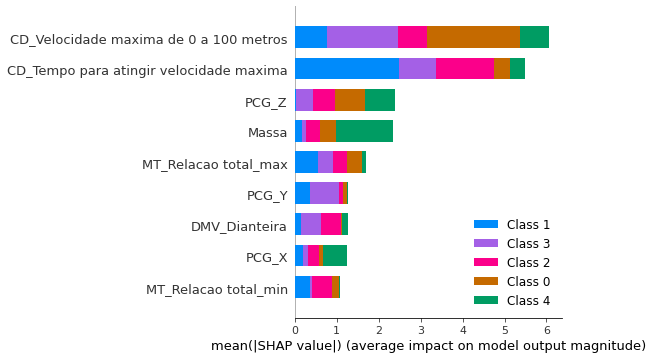

In [106]:
# Crie um objeto explainer
explainer = shap.Explainer(model_XGB, X_treino)

# Calcule os valores Shapley para um exemplo de dado específico
shap_values = explainer.shap_values(X_teste)

# Visualize os valores Shapley
shap.summary_plot(shap_values, X_teste)

# Aprimoramento de Parâmetros

## Tuning

In [116]:
# Exemplo de Tuning
param_grid = {
    'n_estimators': [100, 200, 300],  # Número de árvores na floresta
    'max_depth': [3, 4, 5],         # Profundidade máxima das árvores
    'learning_rate': [0.1, 0.01],   # Taxa de aprendizado
    'subsample': [0.8, 0.9, 1.0],   # Fração de amostras usadas para treinamento de cada árvore
    'colsample_bytree': [0.8, 0.9, 1.0],  # Fração de colunas usadas para treinamento de cada árvore
    'min_child_weight': [1, 5, 10],  # Peso mínimo das amostras necessárias em uma folha
    'gamma': [0, 0.1, 0.2],         # Regularização gamma (parâmetro de penalização)
    'reg_alpha': [0, 0.1, 0.2],     # Regularização L1 (parâmetro de penalização)
    'reg_lambda': [1, 1.1, 1.2]     # Regularização L2 (parâmetro de penalização)
}

grid_search = GridSearchCV(estimator=model_XGB, param_grid=param_grid, cv=5)

grid_search.fit(X_treino, Y_treino)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

In [121]:
# Guardar os parâmetros enconntrados fora do código
melhores_parametros = grid_search.best_params_

# Salvar os melhores parâmetros em um arquivo
joblib.dump(melhores_parametros, 'melhores_parametros_vel.pkl')

# Carregar os melhores parâmetros a partir do arquivo
#melhores_parametros = joblib.load('melhores_parametros_vel.pkl')

['melhores_parametros_vel.pkl']

In [117]:
# Ajustar um modelo de XGBoost
model_XGB.fit(X_treino, Y_treino)

# Configure o modelo com os melhores parâmetros
model_XGB.set_params(**best_params)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [118]:
# Avaliação do desempenho do modelo 
Y_pred = model_XGB.predict(X_teste)

acuracia = accuracy_score(Y_teste, Y_pred)
relatorio_classificacao = classification_report(Y_teste, Y_pred)
    
print(f"Desempenho para Extreme Gradient Boosting:")
print(f'Acurácia: {acuracia:.2f}')
print('Relatório de Classificação:')
print(relatorio_classificacao)

Desempenho para Extreme Gradient Boosting:
Acurácia: 0.93
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97        63
           1       1.00      0.94      0.97        64
           2       0.89      0.95      0.92        65
           3       0.94      0.84      0.89        58
           4       0.87      0.94      0.91        36

    accuracy                           0.93       286
   macro avg       0.93      0.93      0.93       286
weighted avg       0.94      0.93      0.93       286



## Redução de Dimensão

In [ ]:
# Selecione um número específico de características mais importantes
num_caracteristicas_selecionadas = 3  # Por exemplo, selecione as 3 mais importantes

X_treino_selecionado = X_treino[:, indices_ordenados[:num_caracteristicas_selecionadas]]
X_teste_selecionado = X_teste[:, indices_ordenados[:num_caracteristicas_selecionadas]]

# Em seguida, treine seu modelo no conjunto de dados com características selecionadas
model_XGB.fit(X_treino_selecionado, Y_treino)

In [ ]:
# Avaliação do desempenho do modelo usando as métricas de erro quadrático médio (RMSE) e o coeficiente de determinação (R2).
Y_pred = model_XGB.predict(X_teste)

acuracia = accuracy_score(Y_teste, Y_pred)
relatorio_classificacao = classification_report(Y_teste, Y_pred)
    
print(f"Desempenho para Extreme Gradient Boosting:")
print(f'Acurácia: {acuracia:.2f}')
print('Relatório de Classificação:')
print(relatorio_classificacao)

# Predição

In [ ]:
# Valor único para fazer a previsão
X_prev = np.array([6]).reshape(-1, 1) # Colocar os valores pedidos

# Faça a previsão
previsao = modelo_carregado.predict(X_prev)

# Imprima a previsão
print(f'A previsão para X_prev é: {previsao[0]:.2f}')